## Задача № 3 (для 2 курса)

Название: Автоматизация обработки машиночитаемых документов.
 
Описание: Вам будет выдан набор данных документов из системы документооборота небольшой вымышленной компании. На основе этого набора данных вам нужно построить граф знаний о компании, который включает:

● 	Организационную структуру (список подразделений). Есть

● 	Список сотрудников 

●  и их должностей. 

● 	Должностные обязанности и полномочия сотрудников.

На основе построенного графа знаний нужно разработать систему, которая ищет ошибки в проверочных документах (10 правильных документов, 10 документов с ошибками), например:

● 	Опечатки в названиях подразделений или ФИО сотрудников.

● 	Несуществующие подразделения или сотрудники, ошибки в должностях.

● 	Несоответствие тематики документа подразделению, в которое он направлен для исполнения (в бухгалтерию направлен документ с задачей по ИТ).
 
Ссылка на набор данных – https://www.dropbox.com/sh/d5h5f3yrql8x392/AACQ2WYa5qYCqjC8QuVZ5TJ4a?dl=1 

Вам будет передана открытая часть датасета с разметкой, закрытая часть датасета без разметки и проверочные документы (20 документов для подзадачи обнаружения ошибок в документах).
 
Требования к решению:
1.   Код программы построения графа знаний о компании (ссылка на GitHub), с помощью которого можно ответить на вопросы:
a.   Количество отделов.
b.   Количество сотрудников.
c.	К какому отделу относится конкретная задача.
2.   Код программы поиска документов с ошибками на основе графа знаний (ссылка на GitHub).
3.   Документы, в которых найдены ошибки.
 
Критерии оценки:
● 	За каждый найденный документ с ошибкой начисляется 10 баллов.
● 	За каждый документ, представленный как ошибочный, но в котором ошибки на самом деле нет, назначается штраф -1 балл.
 
Советы по реализации:
1.   Извлечь именованные сущности (NER) из текста можно с помощью библиотеки spacy (https://spacy.io/), pullenti, natasha или соответствующих моделей с huggingface (https://huggingface.co/).
2.   Для сущностей, для которых не удастся найти типовые предобученные модели (например, сущность «Задача» или «Департамент») организовать обучение модели с использованием открытой части датасета.
3.   Для построения графа связей в организации рекомендуется использовать библиотеку NetworkX - https://networkx.org/

### Устанавливаем библиотеки

# Решение

1. task_text: разбить на предложения. Выявить функционал. FIO_POSITION: ФИО, должность, функционал, отдел (не необходимо).
2. task_responsibles_people: - вывявить ФИО, должность, task_responsibles_groups: добавить отдел.
3. Собрать мешок слов: ФИО, должность, функционал, отдел.
4. Векторизировать мешок слов.
5. Из отделов построить 8 классов.
6. Обучить реккурентную нейросеть LSTM или GRU.
7. Протестировать на тестовом наборе данных.
8. Построить граф знаний.
9. Написать функцию соответствия предсказания с графом знаний.
10. Сделать презентацию проекта.

In [2]:
!pip install nltk
!pip install navec
!pip install pandas
!pip install natasha
!pip install matplotlib
!pip install python-docx
!pip install scikit-learn

!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

!pip install networkx
#!pytest networkx
#!pytest --pyargs networkx

!pip install pymorphy2

2023-01-22 23:35:54.963038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 23:35:57.243935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 23:35:57.243970: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 23:36:03.719414: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import download
from nltk.tokenize import sent_tokenize, word_tokenize

from navec import Navec
from docx import Document
from IPython.display import display
from sklearn.model_selection import train_test_split

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,
    Doc
)

from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, GRU
from keras.preprocessing.text import Tokenizer

# Морфологический анализ
from pymorphy2 import MorphAnalyzer

# Синтаксический анализ
from spacy import load

2023-01-22 23:36:46.247525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 23:36:46.391744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-22 23:36:46.391765: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-22 23:36:47.192541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
directory = 'hackaton_2023_01/task_3/full_dataset/json/'
data = []
for n in range(9999):
    name = str(n) + '.json'
    try:
        with open(directory + name, "r") as readFile:
            jsonData = json.load(readFile)
            jsonData["id"] = n
            data.append(jsonData)
    except ValueError:
        continue

In [22]:
with open('merged_data.json', "r") as readFile:
    merge_data = json.load(readFile)

### Определяем количество департаментов в компании

In [23]:
DEPARTMENTS = []
for n in range(10000):
    try:
        for i in range(1,30):
            DEPARTMENTS.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_groups'])
    except KeyError:
        continue
    except IndexError:
        continue

In [24]:
FIO_POSITION = []
for n in range(10000):
    try:
        for i in range(1,20):
            FIO_POSITION.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_responsibles_people'])
    except KeyError:
        continue
    except IndexError:
        continue

In [25]:
TASK = []
for n in range(10000):
    try:
        for i in range(1,30):
            TASK.append(merge_data[n]['Tasks']['Task{}'.format(i)]['task_text'])
    except KeyError:
        continue
    except IndexError:
        continue

In [26]:
POSITION = []
for n in range(10000):
    try:
        for i in range(1,30):
            POSITION.append(merge_data[n]['Tasks']['Global_supervisor'][i])
    except KeyError:
        continue
    except IndexError:
        continue

### Очищаем данные

In [27]:
def text_split(text: str):
    pouch_of_words = []
    for line in text:
        line = line.split()
        pouch_of_words.append(line)
    return pouch_of_words

In [11]:
#text_split(FIO_POSITION[:2])

In [28]:
def token_words_split(text: str):
    pouch_of_words = []
    if type(text) == list:
        for line in text:
            TOKENIZER = word_tokenize(line)
            pouch_of_words.append(TOKENIZER)
        return pouch_of_words

#pouch_of_words = token_words_split(FIO_POSITION[:2])
#pouch_of_words

In [29]:
def split_spacy(text: str):
    pouch_of_words = []
    nlp = load('ru_core_news_sm')
    if type(text) == list:
        for line in text:
            doc = nlp(line)
            for token in doc:
                pouch_of_words.append(token)
    return pouch_of_words

In [ ]:
#split_spacy(FIO_POSITION[:2])

In [30]:
download('punkt')
def sentence(text: str):
    sentences = sent_tokenize(text)
    return sentences

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Морфологический анализ

In [31]:
morph = MorphAnalyzer()

In [32]:
def morph_word(words: str):
    words = split_spacy(words)
    morph_words = []
    for word in words:
        print(word)

#morph_word(POSITION[:1])

### Синтаксический анализ

### Разделяем текст на предложения

In [33]:
download('punkt')
def sentence(text: str):
    pouch_of_sentence = []
    if type(text) == list:
        for line in text:
            sentences = sent_tokenize(line)
            pouch_of_sentence.append(sentences)
    return str(pouch_of_sentence)
    
text = sentence(FIO_POSITION[10:12])
text

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


"[['Контроль над выполнением настоящего распоряжения оставляю за собой'], ['Обеспечение выполнения возложить на специалиста третей категории бухгалтерии Александрова А.С.']]"

### Использование библиотеки natasha в данный момент дорабатывается

In [28]:
#segmenter = Segmenter()
#morph_vocab = MorphVocab()

#emb = NewsEmbedding()
#morph_tagger = NewsMorphTagger(emb)
#syntax_parser = NewsSyntaxParser(emb)
#ner_tagger = NewsNERTagger(emb)

#names_extractor = NamesExtractor(morph_vocab)
#dates_extractor = DatesExtractor(morph_vocab)
#money_extractor = MoneyExtractor(morph_vocab)
#addr_extractor = AddrExtractor(morph_vocab)

In [29]:
#syntax_parser = NewsSyntaxParser(emb)

In [30]:
#doc_n = Doc(text)

In [ ]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [ ]:
#doc_n.parse_syntax(syntax_parser)

In [ ]:
#for tocken in doc_n.tokens:
#    print(tocken)

In [ ]:
#doc_n.sents[0].syntax.print()

### Выявление ФИО, должности, специализации

In [32]:
#FIO = []

#for tocken in doc_n.tokens:
#    if tocken.rel == 'flat:name' or tocken.rel == 'appos':
#        if tocken.rel == 'appos':
#            surn = tocken.text 
#            if surn in FIO:
#                pass
#            else:
#                FIO.append(surn)
#        elif tocken.rel == 'flat:name':
#            IO = tocken.text + '.'      
#            FIO.append(IO)

In [ ]:
#doc_n.segment(segmenter) 

In [ ]:
#doc_n.tag_morph(morph_tagger)

In [ ]:
#doc_n.tag_ner(ner_tagger)

In [ ]:
#doc_n.parse_syntax(syntax_parser)

In [ ]:
#display(doc_n.tokens[:5])

In [ ]:
#display(doc_n.sents)

In [ ]:
#display(doc_n.tokens)

In [33]:
#for span in doc_n.spans:
#    span.normalize(morph_vocab)
   
#
#keywords = {_.text: _.normal for _ in doc_n.spans if _.text != _.normal}
#print(span)

In [34]:
#for token in doc_n.tokens:
#    token.lemmatize(morph_vocab)
    
#{_.text: _.lemma for _ in doc_n.tokens}

### Создание дистрибутивно-семантической модели

In [ ]:
#!curl https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
#navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
#navec['абакумов']

### Построение датафрейма

#### Определение числа департаментов и их классиикация

In [34]:
DEPARTMENTS = set(DEPARTMENTS)
DEPARTMENTS_list = list(DEPARTMENTS)

In [35]:
value = []
for i in range(1,9):
    value.append(i)

In [36]:
def classes(list: list) -> dict:
    result = {}

    for n in range(8):
        dep = list[n]
        result[dep] = value[n]

    return result

In [37]:
classes_dep = classes(DEPARTMENTS_list)

### Начало работы с моделью

In [38]:
df = pd.json_normalize(merge_data)

df.set_index('id', inplace=True)
df.sort_index(inplace=True) # сортировка по индексу=id 

df.columns = df.columns.str.replace("Tasks.", "")

KeyError: "None of ['id'] are in the columns"

In [39]:
df.head()

,Tasks.Task1.task_text,Tasks.Task1.task_responsibles_people,Tasks.Task1.task_responsibles_groups,Tasks.Task1.task_deadline,Tasks.Global_supervisor,Tasks.Global_deadline,Tasks.Task2.task_text,Tasks.Task2.task_responsibles_people,Tasks.Task2.task_responsibles_groups,Tasks.Task2.task_deadline,...,Tasks.Task7.task_responsibles_groups,Tasks.Task7.task_deadline,Tasks.Task8.task_text,Tasks.Task8.task_responsibles_people,Tasks.Task8.task_responsibles_groups,Tasks.Task8.task_deadline,Tasks.Task9.task_text,Tasks.Task9.task_responsibles_people,Tasks.Task9.task_responsibles_groups,Tasks.Task9.task_deadline
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,Административно-хозяйственный отдел,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,Служба ИТ,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,Служба ИТ,"[12 авг 13, 1376244000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,Отдел разработки систем,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,Отдел разработки систем,"[01 января 2018 года, 1514746800.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,Бухгалтерия,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,Бухгалтерия,"[17.09.13, 1379354400.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,Бухгалтерия,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,Бухгалтерия,"[26.09.2016, 1474830000.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
#df = pd.read_csv('df_all.csv')

In [41]:
df = df.replace(classes_dep)

In [49]:
df_not_dead_line = df.drop(['Tasks.Global_deadline','Tasks.Task1.task_deadline','Tasks.Task2.task_deadline','Tasks.Task3.task_deadline',
                            'Tasks.Task4.task_deadline','Tasks.Task5.task_deadline','Tasks.Task6.task_deadline','Tasks.Task7.task_deadline',
                            'Tasks.Task8.task_deadline','Tasks.Task9.task_deadline'], axis = 1)

In [50]:
df = df.fillna(0)

### Разделение задания на предложения

In [51]:
for n in range(len(df)):
    try:
        df['Task{}.task_text'.format(n)][n] = df['Task{}.task_text'.format(n)][n].split('.')[0]
    except TypeError:
        continue
    except AttributeError:
        continue
    except IndexError:
        continue
    except KeyError:
        continue

In [ ]:
#df_no_deadline.to_csv('df_no_deadline.csv')

## Построение модели классификации (только по отделам)

In [57]:
X = df.drop(['Tasks.Task1.task_responsibles_groups','Tasks.Task2.task_responsibles_groups','Tasks.Task3.task_responsibles_groups',
             'Tasks.Task4.task_responsibles_groups','Tasks.Task5.task_responsibles_groups','Tasks.Task6.task_responsibles_groups',
             'Tasks.Task7.task_responsibles_groups','Tasks.Task8.task_responsibles_groups','Tasks.Task9.task_responsibles_groups'], axis = 1)
X.head()

,Tasks.Task1.task_text,Tasks.Task1.task_responsibles_people,Tasks.Task1.task_deadline,Tasks.Global_supervisor,Tasks.Global_deadline,Tasks.Task2.task_text,Tasks.Task2.task_responsibles_people,Tasks.Task2.task_deadline,Tasks.Task3.task_text,Tasks.Task3.task_responsibles_people,...,Tasks.Task6.task_deadline,Tasks.Task7.task_text,Tasks.Task7.task_responsibles_people,Tasks.Task7.task_deadline,Tasks.Task8.task_text,Tasks.Task8.task_responsibles_people,Tasks.Task8.task_deadline,Tasks.Task9.task_text,Tasks.Task9.task_responsibles_people,Tasks.Task9.task_deadline
0,Закупить книги. Срок завершения: 19 апр 15.,Ответственность за исполнение распоряжения воз...,"[19 апр 15, 1429383600.0]",[Ответственность за исполнение распоряжения во...,"[11 апреля 2013 года, 1365616800.0]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Провести анализ поставщиков для замены вышедше...,Ответственность за исполнение распоряжения воз...,"[24 октября 12, 1351015200.0]",[Ответственность за исполнение распоряжения во...,"[03 июня 2013 года, 1370196000.0]",Выполнить ремонт кабеля сети передачи данных м...,Контроль над выполнением приказа возложить на ...,"[12 авг 13, 1376244000.0]",Создать и настроить виртуальную машину в соотв...,Контроль над исполнением распоряжения оставить...,...,0,0,0,0,0,0,0,0,0,0
2,Провести рефакторинг программного обеспечения ...,Контроль над исполнением распоряжения оставить...,"[24.12.20, 1608750000.0]",[Контроль над исполнением распоряжения оставит...,"[08 окт 2014 г., 1412704800.0]",Провести рефакторинг программного обеспечения ...,Ответственным за исполнение настоящего приказа...,"[01 января 2018 года, 1514746800.0]",Провести анализ накопленного технического долг...,За контроль над исполнением распоряжения назна...,...,"[18.11.17, 1510945200.0]",0,0,0,0,0,0,0,0,0
3,Оплатить командировочные расходы.\nОпределить ...,Контроль над выполнением настоящего распоряжен...,"[26 июля 2019 г., 1564081200.0]",[Контроль над выполнением настоящего распоряже...,"[10.12.18, 1544382000.0]",Провести аудит персональных данных в информаци...,Обеспечение выполнения возложить на специалист...,"[17.09.13, 1379354400.0]",Перечислить необходимые средства на закупку об...,Контроль над выполнением настоящего распоряжен...,...,0,0,0,0,0,0,0,0,0,0
4,Согласовать смету на выполнение работ компание...,Контроль над выполнением настоящего распоряжен...,"[12 янв 2019 г., 1547233200.0]",[Контроль над выполнением настоящего распоряже...,"[19.03.2016, 1458327600.0]",Выделить средства на проведение обучения.\nУст...,Ответственным за исполнение настоящего приказа...,"[26.09.2016, 1474830000.0]",0,0,...,0,0,0,0,0,0,0,0,0,0


### Определение целевой переменной

In [59]:
y = df['Tasks.Task1.task_responsibles_groups']
y.head()

0    3
1    6
2    1
3    8
4    8
Name: Tasks.Task1.task_responsibles_groups, dtype: int64

In [60]:
X.shape, y.shape

((10000, 29), (10000,))

## Определение словарей для токенизации и векторизации слов

In [62]:
task_1 = X['Tasks.Task1.task_text']
task_2 = X['Tasks.Task2.task_text']
task_3 = X['Tasks.Task3.task_text']
task_4 = X['Tasks.Task4.task_text']
task_5 = X['Tasks.Task5.task_text']
task_6 = X['Tasks.Task6.task_text']
task_7 = X['Tasks.Task7.task_text']
task_8 = X['Tasks.Task8.task_text']
task_9 = X['Tasks.Task9.task_text']

Task1_task_responsibles_people = X['Tasks.Task1.task_responsibles_people']
Task2_task_responsibles_people = X['Tasks.Task2.task_responsibles_people']
Task3_task_responsibles_people = X['Tasks.Task3.task_responsibles_people']
Task4_task_responsibles_people = X['Tasks.Task4.task_responsibles_people']
Task5_task_responsibles_people = X['Tasks.Task5.task_responsibles_people']
Task6_task_responsibles_people = X['Tasks.Task6.task_responsibles_people']
Task7_task_responsibles_people = X['Tasks.Task7.task_responsibles_people']
Task8_task_responsibles_people = X['Tasks.Task8.task_responsibles_people']
Task9_task_responsibles_people = X['Tasks.Task9.task_responsibles_people']

Global_supervisor = X['Tasks.Global_supervisor']

### Токенизация и векторизация слов и предложений

In [69]:
num_words = 10000
max_review_len = 100
tokenizer = Tokenizer(num_words=num_words)

In [70]:
tokenizer.fit_on_texts(Task1_task_responsibles_people)

In [71]:
sequences = tokenizer.texts_to_sequences(Task1_task_responsibles_people)

In [72]:
X = utils.pad_sequences(sequences, maxlen=max_review_len)

### Разбиение датасета на тренировчную и тестовую выборки

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    
                                                    test_size=0.1,
                                                    random_state=50)
X_train.shape, y_train.shape

((9000, 100), (9000,))

### Приведение данных к другому типу и категоризация классов

In [74]:
# Количество классов отделов
nb_classes = 8

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_train = utils.to_categorical(y_train - 1, nb_classes)
y_test = utils.to_categorical(y_test - 1, nb_classes)
X_train.shape, y_train.shape

((9000, 100), (9000, 8))

## Создаём нейросеть

### Определение гиперпараметров модели

In [75]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина задания
max_news_len = 100
# Количество классов отделов
nb_classes = 8

### Простая свёрточная сеть

In [76]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            )

2023-01-22 23:53:44.177160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
64/64 [==============================] - 11s 123ms/step - loss: 1.2622 - accuracy: 0.6025 - val_loss: 0.4708 - val_accuracy: 0.8933
Epoch 2/5
64/64 [==============================] - 7s 105ms/step - loss: 0.2868 - accuracy: 0.9095 - val_loss: 0.1713 - val_accuracy: 0.9233
Epoch 3/5
64/64 [==============================] - 7s 107ms/step - loss: 0.2061 - accuracy: 0.9147 - val_loss: 0.1652 - val_accuracy: 0.9389
Epoch 4/5
64/64 [==============================] - 7s 105ms/step - loss: 0.2026 - accuracy: 0.9167 - val_loss: 0.1609 - val_accuracy: 0.9311
Epoch 5/5
64/64 [==============================] - 7s 109ms/step - loss: 0.2020 - accuracy: 0.9173 - val_loss: 0.1614 - val_accuracy: 0.9211


In [77]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 conv1d (Conv1D)             (None, 96, 250)           40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 393,410
Trainable params: 393,410
Non-trainable params: 0
__________________________________________________

### Смотрим графики по визуализации предсказаний для определения переобучения модели

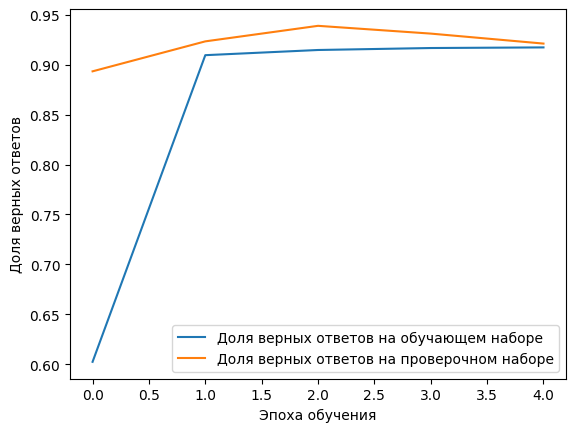

In [78]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Сеть LSTM

In [79]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(8, activation='softmax'))

In [80]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [81]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              )

Epoch 1/5
64/64 [==============================] - 9s 82ms/step - loss: 1.8396 - accuracy: 0.3538 - val_loss: 1.4005 - val_accuracy: 0.7167
Epoch 2/5
64/64 [==============================] - 5s 70ms/step - loss: 1.0275 - accuracy: 0.7278 - val_loss: 0.6747 - val_accuracy: 0.7444
Epoch 3/5
64/64 [==============================] - 4s 64ms/step - loss: 0.5630 - accuracy: 0.8009 - val_loss: 0.4181 - val_accuracy: 0.8756
Epoch 4/5
64/64 [==============================] - 4s 58ms/step - loss: 0.3909 - accuracy: 0.8881 - val_loss: 0.2962 - val_accuracy: 0.9311
Epoch 5/5
64/64 [==============================] - 4s 59ms/step - loss: 0.3029 - accuracy: 0.9163 - val_loss: 0.2344 - val_accuracy: 0.9389


In [82]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 323,272
Trainable params: 323,272
Non-trainable params: 0
_________________________________________________________________


### Смотрим графики по визуализации предсказаний для определения переобучения модели

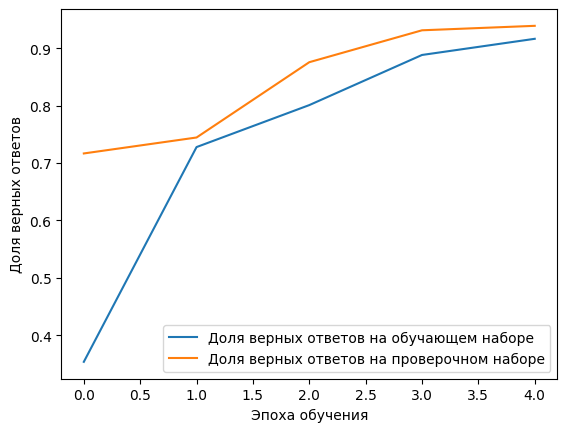

In [83]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Сеть GRU

In [84]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(32))
model_gru.add(Dense(8, activation='softmax'))

In [85]:
model_gru.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [86]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 326,600
Trainable params: 326,600
Non-trainable params: 0
_________________________________________________________________


In [87]:
history_gru = model_gru.fit(X_train, 
                            y_train,
                            epochs=10,
                            batch_size=128,
                            validation_split=0.1,
                            )

Epoch 1/10
64/64 [==============================] - 12s 99ms/step - loss: 1.7990 - accuracy: 0.3707 - val_loss: 1.2961 - val_accuracy: 0.7056
Epoch 2/10
64/64 [==============================] - 5s 82ms/step - loss: 0.7890 - accuracy: 0.7969 - val_loss: 0.4418 - val_accuracy: 0.8978
Epoch 3/10
64/64 [==============================] - 5s 79ms/step - loss: 0.3816 - accuracy: 0.9020 - val_loss: 0.2640 - val_accuracy: 0.9233
Epoch 4/10
64/64 [==============================] - 5s 78ms/step - loss: 0.2579 - accuracy: 0.9168 - val_loss: 0.1932 - val_accuracy: 0.9233
Epoch 5/10
64/64 [==============================] - 5s 76ms/step - loss: 0.2238 - accuracy: 0.9158 - val_loss: 0.1876 - val_accuracy: 0.9211
Epoch 6/10
64/64 [==============================] - 5s 72ms/step - loss: 0.2128 - accuracy: 0.9172 - val_loss: 0.1770 - val_accuracy: 0.9311
Epoch 7/10
64/64 [==============================] - 5s 75ms/step - loss: 0.2081 - accuracy: 0.9149 - val_loss: 0.1728 - val_accuracy: 0.9211
Epoch 8/10
6

### Смотрим графики по визуализации предсказаний для определения переобучения модели

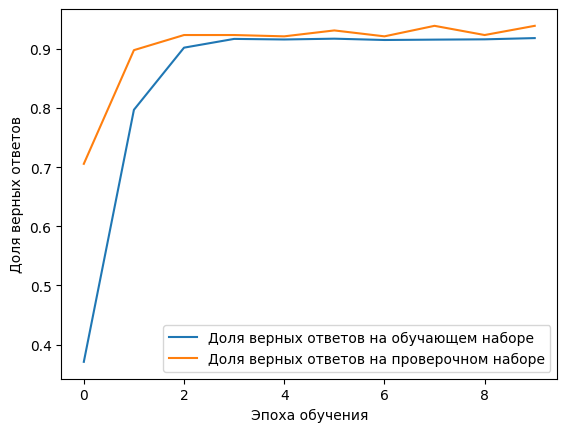

In [88]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### Метрики тестовой выборки для свёрточной нейросети сети

In [89]:
model_cnn.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 1s 13ms/step - loss: 0.1770 - accuracy: 0.9230


[0.1769861876964569, 0.9229999780654907]

### Метрики тестовой выборки для сети LSTM

In [90]:
model_lstm.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 2s 16ms/step - loss: 0.2448 - accuracy: 0.9290


[0.24477005004882812, 0.9290000200271606]

### Метрики тестовой выборки для сети GRU

In [91]:
model_gru.evaluate(X_test, y_test, verbose=1)

32/32 [==============================] - 2s 16ms/step - loss: 0.1797 - accuracy: 0.9290


[0.17974741756916046, 0.9290000200271606]

### Проверка документа из датасетов output_decrees

In [92]:
directory = 'hackaton_2023_01/task_3/output_decrees/docx/'

print("Введите название файла: ")
name = str(input())

def file(name):
    fileText = ''

    document = Document(directory + name)
    for paragraph in document.paragraphs:
        fileText += paragraph.text + '\n'
    print(fileText)
    return fileText

fileText = file(name)

Введите название файла: 

Бухгалтерия


О закупке
Для организации мероприятия "День заказчика" приказываю:
a. Внести изменения в ОРД согласно прилагаемому Перечню.
ПЕРЕЧЕНЬ ИЗМЕНЕНИЙ, ВНОСИМЫХ В ОРД

	a.. Внести в Регламент, утвержденный приказом Генерального директора от 11.05.2016 N 276, изменение, исключив из пункта 1.11 слова "а также деятельность Руководителя удаленного офиса".
Ответственность за исполнение задачи возложить на Контент менеджера Роговцова Беньямина.
Установить срок выполнения задачи до 19.08.22.

		○ пункт 5.1.2 дополнить абзацем четвертым следующего содержания:
"При официальной переписке с межгосударственными (международными) органами, компетентными органами и должностными лицами иностранных государств, иностранными гражданами и организациями используется отдельный бланк с продольным расположением реквизитов на двух языках - русском и английском (приложение N 61)." Определить срок исполнения задачи вплоть до 0.

b. пункт 2.4.1.3 изложить в следующей редакции:
"2.4

# Векторизация текста

In [93]:
sequence = tokenizer.texts_to_sequences([fileText])

In [94]:
data = utils.pad_sequences(sequence, maxlen=max_review_len)

### Предсказание модели cnn

In [95]:
result = model_cnn.predict(data)

1/1 [==============================] - 0s 224ms/step


### Вывод результата

In [96]:
np.round(result, 2)

array([[0.03, 0.23, 0.01, 0.03, 0.01, 0.35, 0.01, 0.33]], dtype=float32)

In [97]:
classes_dep

{'Отдел разработки систем': 1,
 'Отдел архитектуры': 2,
 'Административно-хозяйственный отдел': 3,
 'Отдел проектирования': 4,
 'Отдел тестирования': 5,
 'Служба ИТ': 6,
 'Отдел эксплуатации': 7,
 'Бухгалтерия': 8}

### Модель LSTM

In [98]:
result = model_lstm.predict(data)

1/1 [==============================] - 1s 1s/step


In [99]:
np.round(result, 2)

array([[0.07, 0.19, 0.12, 0.09, 0.15, 0.03, 0.2 , 0.15]], dtype=float32)

In [100]:
classes_dep

{'Отдел разработки систем': 1,
 'Отдел архитектуры': 2,
 'Административно-хозяйственный отдел': 3,
 'Отдел проектирования': 4,
 'Отдел тестирования': 5,
 'Служба ИТ': 6,
 'Отдел эксплуатации': 7,
 'Бухгалтерия': 8}

### Предсказание модели GRU

In [101]:
result = model_gru.predict(data)

1/1 [==============================] - 1s 1s/step


In [102]:
np.round(result, 2)

array([[0.  , 0.01, 0.  , 0.92, 0.02, 0.  , 0.01, 0.04]], dtype=float32)

In [103]:
classes_dep

{'Отдел разработки систем': 1,
 'Отдел архитектуры': 2,
 'Административно-хозяйственный отдел': 3,
 'Отдел проектирования': 4,
 'Отдел тестирования': 5,
 'Служба ИТ': 6,
 'Отдел эксплуатации': 7,
 'Бухгалтерия': 8}

# Выводы:

На документах, не учавствовавших в в обучении модели предсказывают классы по большему 
синтаксическому совпадению слов в загруженном документе, а также по частотности слов, 
относящихся к классам при обучении модели,
в этом документе. 

Для улучшения нейросети необходимо:
    
    1. Провести семантический анализ предложения. Использовать словарь синонимов к ключевым словам.
    
    2. Использовать порядок слов в предложении.
    
    3. Применить лямбда исчисления и разбить слова предложения на примитивы.
    
        - Слово.
        
        - Его определение.
        
        - Пример сочетания заданного слова с другими.
        
        - Составление фраз и предложений с этим словом.
        
    4. Определить связи между собой различными смысловыми отношениями: соединительными, 
пояснительными, противительными, временными и пр. 

    5. Определить основные виды связи:
    
        Параллельные связи:

        - Одинаковый порядок слов. 

        - Одинаковые грамматические формы слов.

        - Вводные слова и наречия места, времени. 	

        Цепнык связи:
        
        - Повтор ключевого слова. 

        - Замена его синонимом, синонимическим оборотом, местоимением или однокоренным словом. 
        Для этого сделать или хагрузить словарь синонимов.

        - Повтор того или иного члена предложения.

        - Семантические и ассоциативные связи (найти и создать правила в блиблотеки yargy).

    6. Провести смысловой анализ текста.
    7. Провести смысловой анализ предложения. (Некоторые пункты пересекаются.)

### Строим однонаправленный граф (В процессе разработки)

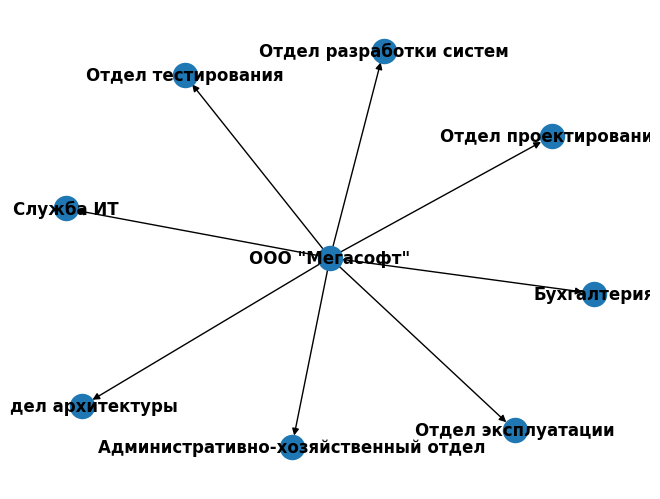

In [104]:
DG = nx.DiGraph()

DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[0]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[1]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[2]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[3]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[4]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[5]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[6]) 
DG.add_edge('ООО "Мегасофт"', DEPARTMENTS_list[7]) 

nx.draw(DG, with_labels=True, font_weight='bold')